# Sprint21
## 自然言語処理入門

In [1]:
import numpy as np
import pandas as pd

## IMDB映画レビューデータセットの準備

In [24]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-12-26 23:40:32--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
ai.stanford.edu (ai.stanford.edu) をDNSに問いあわせています... 171.64.68.10
ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84125825 (80M) [application/x-gzip]
`aclImdb_v1.tar.gz.1' に保存中

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M   394KB/s 時間 9m 58s   

2019-12-26 23:50:30 (137 KB/s) - `aclImdb_v1.tar.gz.1' へ保存完了 [84125825/84125825]



In [25]:
# 解凍
!tar zxf aclImdb_v1.tar.gz

In [26]:
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup

In [2]:
#読み込み
from sklearn.datasets import load_files

train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target

test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


## BOW

In [11]:
#例として、IMDBデータセットからある3文の最初の5単語を抜き出したものを用意
#この3文にBoWを適用させてみます。scikit-learnのCountVectorizerを利用
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()

# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)
display(bow)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


array([[0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 0, 1, 0],
       [0, 2, 0, 0, 0, 0, 0, 3]], dtype=int64)

In [16]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


## 【問題1】BoWのスクラッチ実装

In [21]:
text=["This movie is SOOOO funny!!!",
               "What a movie! I never",
               "best movie ever!!!!! this movie"]

['This', 'movie', 'is', 'SOOOO', 'funny!!!']

In [31]:
import numpy as np
import pandas as pd

def BoW(data, two_gram=False):
    data=data.copy()
    
    vocabulary=[]
    
    #不要な記号を削除してwordを小文字に統一
    for i in range(len(data)):
        data[i]=data[i].translate(str.maketrans({'!': None, ',':None, '.': None}))
        data[i]=data[i].lower()
        #TEXTを分割して格納
        split_text=data[i].split()

        if not two_gram:
            for word in split_text:
                if word not in vocabulary:
                    vocabulary.append(word)
        else:
            for j in range(len(split_text)-1):
                word=split_text[j]+" "+split_text[j+1]
                if word not in vocabulary:
                    vocabulary.append(word)
  
    bow=np.zeros((len(data), len(vocabulary)))
    for i in range(len(vocabulary)):
        for j in range(len(data)):
            if not two_gram:
                for word in data[j].split():
                    if vocabulary[i]==word:
                        bow[j,i]+=1
            
        else:
            for k in range(len(data[j].split())-1):
                word=data[j].split()[k]+" "+data[j].split()[k+1]
                if vocabulary[i]==word:
                    bow[j,i]+=1

    bow= pd.DataFrame(bow, dtype=int)
    bow.columns=vocabulary
    bow=bow.sort_index(axis=1)

    return bow

1-gram

In [32]:
BoW(text)

,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0,0,0,1,0,1,1,0,1,1,0
1,1,0,0,0,1,0,1,1,0,0,1
2,0,1,1,0,0,0,2,0,0,1,0


2-gram

In [33]:
BoW(text,2)

,a movie,best movie,ever this,i never,is soooo,movie ever,movie i,movie is,soooo funny,this movie,what a
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,1,0,0,0,1,0


## 【問題2】TF-IDFの計算
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。

TF-IDFの計算にはscikit-learnの以下のどちらかのクラスを使用してください。

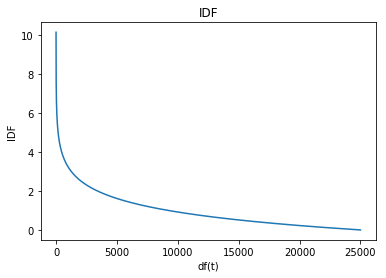

In [10]:
#IDF
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

In [17]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


In [18]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wakaichiaki/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


## 【問題2】TF-IDFの計算

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(stop_words=stop_words, norm=None)
X_train=vectorizer.fit_transform(x_train)
X_test=vectorizer.transform(x_test)
print(X_train.shape)


(25000, 74704)


## 【問題3】TF-IDFを用いた学習

In [35]:
#ロジスティック回帰
from sklearn.linear_model import LinearRegression
Lr=LinearRegression()
Lr.fit(X_train,y_train)
y_pred=Lr.predict(X_test)
acc=np.where(y_test==y_pred,1,0).mean()
print(acc)

0.0


## 【問題4】TF-IDFのスクラッチ実装

In [53]:
#前処理

texts=["This movie is SOOOO funny!!!",
"What a movie! I never",
"best movie ever!!!!! this movie"]

split_text=list(map(lambda x:x.split(),texts))
N=sum(len(i) for i in split_text)
for word in vocabulary:
    #TF(count関数)
    count=0
    for text in texts:
            count+=text.count(word)
        idf_t[word]=np.log2(N/count)

['This', 'movie', 'is', 'SOOOO', 'funny!!!']

In [75]:
#標準的な式
def tf_idf(data, sklearn=False):
    data=list(map(lambda x: x.split(), data))
    N=sum(len(d) for d in data)
    word_list=[]
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] not in word_list:
                word_list.append(data[i][j])

    ans=np.zeros((len(data), len(word_list)))
    for i in range(len(word_list)):
        df=sum(list(map(lambda x: word_list[i] in x, data)))
        if not sklearn:
            idf=np.log(N/df)
        else:
            idf=np.log((1+N)/(1+df)) + 1
        for j in range(len(data)):
            if not sklearn:
                tf=(data[j].count(word_list[i]))/len(data[j])
            else:
                tf=data[j].count(word_list[i])

            ans[j,i]=tf*idf

    return ans

In [76]:
tf_idf(texts)

array([[0.4029806 , 0.32188758, 0.54161004, 0.54161004, 0.54161004,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.32188758, 0.        , 0.        , 0.        ,
        0.54161004, 0.54161004, 0.54161004, 0.54161004, 0.        ,
        0.        ],
       [0.4029806 , 0.64377516, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.54161004,
        0.54161004]])

In [77]:
tf_idf(texts,True)

array([[2.67397643, 2.38629436, 3.07944154, 3.07944154, 3.07944154,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 2.38629436, 0.        , 0.        , 0.        ,
        3.07944154, 3.07944154, 3.07944154, 3.07944154, 0.        ,
        0.        ],
       [2.67397643, 4.77258872, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.07944154,
        3.07944154]])

## Word2Vec

In [9]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

print("語彙の一覧 : {}".format(model.wv.vocab.keys()))

for vocab in model.wv.vocab.keys():
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[-0.03649018 -0.03451699  0.0223731  -0.0260305  -0.00548376 -0.01717443
 -0.00751529 -0.00800426 -0.01083771 -0.02868124]
movieのベクトル : 
[-0.02849093  0.00332045  0.03930696 -0.01505837  0.03857397  0.00435598
 -0.02534084  0.04041808 -0.0382584  -0.0326737 ]
isのベクトル : 
[ 0.04521254 -0.02464501  0.00141867  0.04369242  0.0251048   0.04524075
  0.02586186 -0.03955907  0.01523791  0.03106563]
veryのベクトル : 
[ 0.02441175  0.03616291 -0.00314331  0.04674     0.02312905  0.03426582
  0.03506921 -0.03768704 -0.02048863 -0.04057561]
goodのベクトル : 
[ 0.04714612 -0.03029714 -0.01858344  0.02350336  0.0076986  -0.02268639
 -0.00989144  0.01949742  0.00568453  0.01850162]
filmのベクトル : 
[ 0.01850813  0.02212316  0.01187019  0.04216134 -0.00263665  0.04747287
 -0.01031792  0.04203134  0.0253899  -0.00885164]
aのベクトル : 
[-0.0266642   0.0217545   0.0173151   0.01916134  0.02285735  0.02115839
  0.01632052  0.0435819

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [ ]:
#単語の距離
model.wv.most_similar(positive="good", topn=3)

In [ ]:
#可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocabs = model.wv.vocab.keys()

tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## 【問題5】コーパスの前処理

In [3]:
import re

def preprocessor(text):
    text=re.sub('<[^>]*>', '', text)
    emotions=re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text=(re.sub('[\W]+', ' ', text.lower()) + ''.join(emotions).replace('-', ''))
    text=text.split()
    return text

In [4]:
x_train[100]

"(spoilers)<br /><br />I shoulda figured. The dvd didn't even show the time or how long it was. I thought Wild Cardz was the worst anime movie I'd ever seen. This one is much worse. Makes no sense. Thrown together plot. All so we can see oversized breasts on a figure that doesn't support them. <br /><br />It had to of been a student film. That musta gotten a C grade<br /><br />2/10<br /><br />Quality: 1/10 Entertainment: 6/10 (until I found out it wasn't going to end.) the ending made no darn sense<br /><br />Replayable: 0/10"

In [6]:
X_train=list(map(preprocessor, x_train))
X_test=list(map(preprocessor, x_test))
print(len(X_train))
X_train[100]

25000


['spoilers',
 'i',
 'shoulda',
 'figured',
 'the',
 'dvd',
 'didn',
 't',
 'even',
 'show',
 'the',
 'time',
 'or',
 'how',
 'long',
 'it',
 'was',
 'i',
 'thought',
 'wild',
 'cardz',
 'was',
 'the',
 'worst',
 'anime',
 'movie',
 'i',
 'd',
 'ever',
 'seen',
 'this',
 'one',
 'is',
 'much',
 'worse',
 'makes',
 'no',
 'sense',
 'thrown',
 'together',
 'plot',
 'all',
 'so',
 'we',
 'can',
 'see',
 'oversized',
 'breasts',
 'on',
 'a',
 'figure',
 'that',
 'doesn',
 't',
 'support',
 'them',
 'it',
 'had',
 'to',
 'of',
 'been',
 'a',
 'student',
 'film',
 'that',
 'musta',
 'gotten',
 'a',
 'c',
 'grade2',
 '10quality',
 '1',
 '10',
 'entertainment',
 '6',
 '10',
 'until',
 'i',
 'found',
 'out',
 'it',
 'wasn',
 't',
 'going',
 'to',
 'end',
 'the',
 'ending',
 'made',
 'no',
 'darn',
 'sensereplayable',
 '0',
 '10']

## 【問題6】Word2Vecの学習

In [14]:
model = Word2Vec(min_count=1, size=2) 
model.build_vocab(X_train) 
model.train(X_train, total_examples=model.corpus_count, epochs=model.iter) 

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(22433740, 29769840)

2次元

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


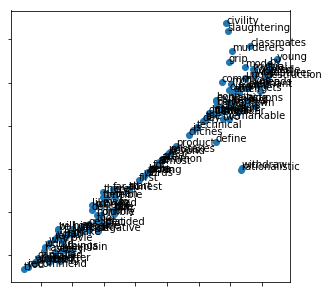

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs=['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 're', 'why', 'two', 'boys', 'young', 'men', 'would', 'do', 'what', 'they', 'did', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their', 'classmates', 'it', 'captures', 'must', 'be', 'beyond', 'a', 'bizarre', 'mode', 'of', 'being', 'for', 'humans', 'who', 'have', 'decided', 'withdraw', 'from', 'common', 'civility', 'in', 'order', 'define', 'own', 'world', 'coupled', 'destruction', 'is', 'not', 'perfect', 'movie', 'but', 'given', 'money', 'time', 'the', 'filmmaker', 'and', 'actors', 'had', 'remarkable', 'product', 'terms', 'explaining', 'motives', 'actions', 'murderers', 'better', 'than', 'elephant', 'film', 'that', 'gets', 'under', 'our', 'rationalistic', 'skin', 'far', 'almost', 'anything', 'are', 'likely', 'see', 'flawed', 'honest', 'with', 'terrible', 'honesty', 'words', 'can', 't', 'describe', 'how', 'bad', 'this', 'i', 'explain', 'by', 'writing', 'only', 'too', 'yourself', 'get', 'at', 'grip', 'horrible', 'really', 'recommend', 'there', 'so', 'many', 'clichés', 'mistakes', 'all', 'other', 'negative', 'things', 'imagine', 'here', 'will', 'just', 'make', 'cry', 'start', 'technical', 'first', 'lot']

tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [16]:
model = Word2Vec(min_count=1, size=20) 
model.build_vocab(X_train) 
model.train(X_train, total_examples=model.corpus_count, epochs=model.iter) 

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(22432644, 29769840)

In [ ]:
２０次元

/Users/wakaichiaki/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


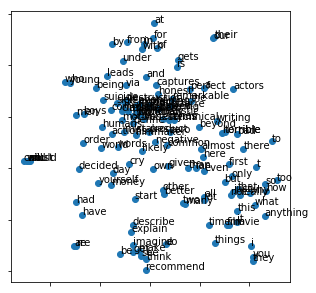

In [17]:
vocabs=['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 're', 'why', 'two', 'boys', 'young', 'men', 'would', 'do', 'what', 'they', 'did', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their', 'classmates', 'it', 'captures', 'must', 'be', 'beyond', 'a', 'bizarre', 'mode', 'of', 'being', 'for', 'humans', 'who', 'have', 'decided', 'withdraw', 'from', 'common', 'civility', 'in', 'order', 'define', 'own', 'world', 'coupled', 'destruction', 'is', 'not', 'perfect', 'movie', 'but', 'given', 'money', 'time', 'the', 'filmmaker', 'and', 'actors', 'had', 'remarkable', 'product', 'terms', 'explaining', 'motives', 'actions', 'murderers', 'better', 'than', 'elephant', 'film', 'that', 'gets', 'under', 'our', 'rationalistic', 'skin', 'far', 'almost', 'anything', 'are', 'likely', 'see', 'flawed', 'honest', 'with', 'terrible', 'honesty', 'words', 'can', 't', 'describe', 'how', 'bad', 'this', 'i', 'explain', 'by', 'writing', 'only', 'too', 'yourself', 'get', 'at', 'grip', 'horrible', 'really', 'recommend', 'there', 'so', 'many', 'clichés', 'mistakes', 'all', 'other', 'negative', 'things', 'imagine', 'here', 'will', 'just', 'make', 'cry', 'start', 'technical', 'first', 'lot']

tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()